In [87]:
import numpy as np 
from keras.datasets import mnist
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [88]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(-1, 784)

x_test = x_test.reshape(-1, 784)

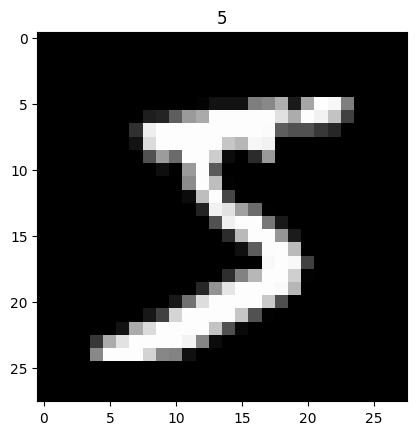

In [91]:
import matplotlib.pyplot as plt 

index = 0

image = x_train[index].reshape(28, 28)

plt.imshow(image, "grey")
plt.title(f"{y_train[index]}")
plt.show()

In [92]:
x_train, x_test = x_train.astype(np.float_), x_test.astype(np.float_)

x_train /= 255
x_test /= 255

print(x_train.max())
print(x_test.min())

1.0
0.0


In [93]:
onv = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

one_hot_y_train = onv.fit_transform(y_train[:, np.newaxis])
one_hot_y_test = onv.fit_transform(y_test[:, np.newaxis])

print(one_hot_y_test.shape)
print(one_hot_y_train.shape)

(10000, 10)
(60000, 10)


In [94]:
x_train, x_val, y_train, y_val = train_test_split(x_train, one_hot_y_train, test_size=0.2)

print(x_train.shape)
print(x_val.shape)

(48000, 784)
(12000, 784)


In [95]:
class GetMiniBatch:
    """
Iterator to get a mini-batch

    Parameters
    ----------
    X : The following forms of ndarray, shape (n_samples, n_features)
      Training data
    y : The following form of ndarray, shape (n_samples, 1)
      Correct answer value
    batch_size : int
      Batch size
    seed : int
      NumPy random seed
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int_)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [98]:
class ScratchSimpleNeuralNetrowkClassifier():
    """
    Simple three-layer neural network classifier

    Parameters
    ----------

    Attributes
    ----------
    """

    def __init__(self, alpha,verbose = True, epoch = 10):
        self.verbose = verbose
        self.alpha = alpha
        self.epoch = epoch
        pass

    def fit(self, X, y, X_val=None, y_val=None):
        """
        Learn a neural network classifier.

        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            Features of training data
        y : The following form of ndarray, shape (n_samples,)
            Correct answer value of training data
        X_val : The following forms of ndarray, shape (n_samples, n_features)
            Features of verification data
        y_val : The following form of ndarray, shape (n_samples,)
            Correct value of verification data
        """
        n_features = X.shape[1]
        n_nodes1 = 400
        n_nodes2 = 200
        output = 10
        self.batch_size = 20
        sigma = 0.01

        # Initialising weights and baises using Guassian distribution method
        self.w1 = sigma * np.random.randn(n_features, n_nodes1)
        self.w2 = sigma * np.random.randn(n_nodes1, n_nodes2)
        self.w3 = sigma * np.random.randn(n_nodes2, output)

        self.b1 =  sigma * np.random.randn(n_nodes1)
        self.b2 = sigma * np.random.randn(n_nodes2)
        self.b3 = sigma * np.random.randn(output)

        # initializing losses
        self.loss_train = np.array([])
        self.loss_val = np.array([])
        
        for _ in range(self.epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)

            for mini_x_train, mini_y_train in get_mini_batch:
                self.forward(mini_x_train)
                self.backward(mini_x_train, mini_y_train)
            
            self.forward(X)
            self.loss_train = np.append(self.loss_train, self.cross_entropy(y))

            if X_val is not None:
                self.forward(X_val)
                self.loss_val = np.append(self.loss_val, self.cross_entropy(y_val))
            
            if self.verbose:
                if X_val is not None:
                    print(self.loss_val)
                else:
                    print(self.loss_train)
        return self
                               


    def predict(self, X):
        """
        Estimate using a neural network classifier.

        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            sample

        Returns
        -------
            The following form of ndarray, shape (n_samples, 1)
            Estimated result
        """
        self.forward(X)
        return np.argmax(self.z3, axis=1)
    
    def forward(self, X):
        # Foward propagation for 3 layer neural network 

        # A = n dot product w + bias 

        # Connection between input and first hidden layer
        self.a1 = X @ self.w1 + self.b1
        self.z1 = self._sigmoid(self.a1)

        # connection between first hidden layer and 2nd hidden layer
        self.a2 = self.z1 @ self.w2 + self.b2
        self.z2 = self._sigmoid(self.a2)

        # connection between 2nd hidden layer and output layer
        self.a3 = self.z2 @ self.w3 + self.b3
        self.z3 = self._softmax(self.a3)

    def _sigmoid(self, a):

        return 1/ (1 + np.exp(a))
    
    def _tanh(self, a):
        return np.tanh(a)
    
    def _softmax(self, a):
        numerator = np.exp(a)
        return numerator / np.sum(np.exp(a), axis=1, keepdims=True)

    def cross_entropy(self, y):
        loss = - np.sum(y * np.log(self.z3 + 1e-7))

        return loss / len(y)
    
    def backward(self,x, y):
        """
        Backward propagation of 3 layer neural network using chain rule

        """
        #third layer
        dA3 = (self.z3 - y) / self.batch_size
        dB3 = np.sum(dA3, axis = 0)
        dW3 = self.z2.T @ dA3
        dZ2 = dA3 @ dW3.T
        # second layer
        dA2 = dZ2 * (1 - self._sigmoid(self.a2)) * self._sigmoid(self.a2)
        dB2 = np.sum(dA2, axis=0)
        dW2 = self.z1.T @ dA2
        dZ1 = dA2 @ self.w2.T

        #first layer
        dA1 = dZ1 * (1 - self._sigmoid(self.a1)) * self._sigmoid(self.a1)
        dB1 = np.sum(dA1, axis=0)
        dW1 = x.T @ dA1

        # updating weights
        self.w1 -= self.alpha * dW1
        self.w2 -= self.alpha * dW2
        self.w3 -= self.alpha * dW3

        # Updating biases
        self.b1 -= self.alpha * dB1
        self.b2 -= self.alpha * dB2
        self.b3 -= self.alpha * dB3


        


    


In [99]:
model = ScratchSimpleNeuralNetrowkClassifier(2e-3, True, 10).fit(x_train, y_train, X_val=x_val, y_val=y_val)

[2.30571791]
[2.30571791 2.30577811]
[2.30571791 2.30577811 2.30455811]
[2.30571791 2.30577811 2.30455811 2.30158424]
[2.30571791 2.30577811 2.30455811 2.30158424 2.29742157]
[2.30571791 2.30577811 2.30455811 2.30158424 2.29742157 2.29331528]
[2.30571791 2.30577811 2.30455811 2.30158424 2.29742157 2.29331528
 2.28986959]
[2.30571791 2.30577811 2.30455811 2.30158424 2.29742157 2.29331528
 2.28986959 2.28717473]
[2.30571791 2.30577811 2.30455811 2.30158424 2.29742157 2.29331528
 2.28986959 2.28717473 2.28514462]
[2.30571791 2.30577811 2.30455811 2.30158424 2.29742157 2.29331528
 2.28986959 2.28717473 2.28514462 2.2836596 ]


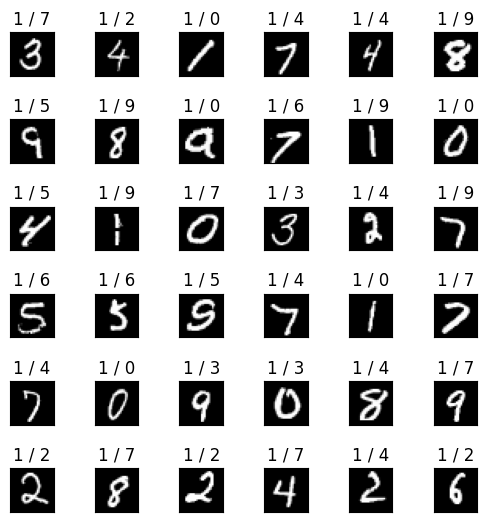

In [100]:

y_pred = model.predict(x_test)
y_val = y_test

num = 36 # How many to display
true_false = y_pred==y_val
false_list = np.where(true_false==False)[0].astype(np.int_)

if false_list.shape[0] < num:
    num = false_list.shape[0]
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
for i in range(num):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    ax.set_title("{} / {}".format(y_pred[false_list[i]],y_val[false_list[i]]))
    ax.imshow(x_val.reshape(-1,28,28)[false_list[i]], cmap='gray')


In [101]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)


0.1135